In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, default_collate
from torchmetrics.classification import MulticlassAccuracy
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import v2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

NUM_CLASSES = 102


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [5]:
cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])


def collate_fn(batch):
    return cutmix_or_mixup(*default_collate(batch))

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
# evaluating the model’s performance on the same training dataset but without performing any gradient updates
train_val_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

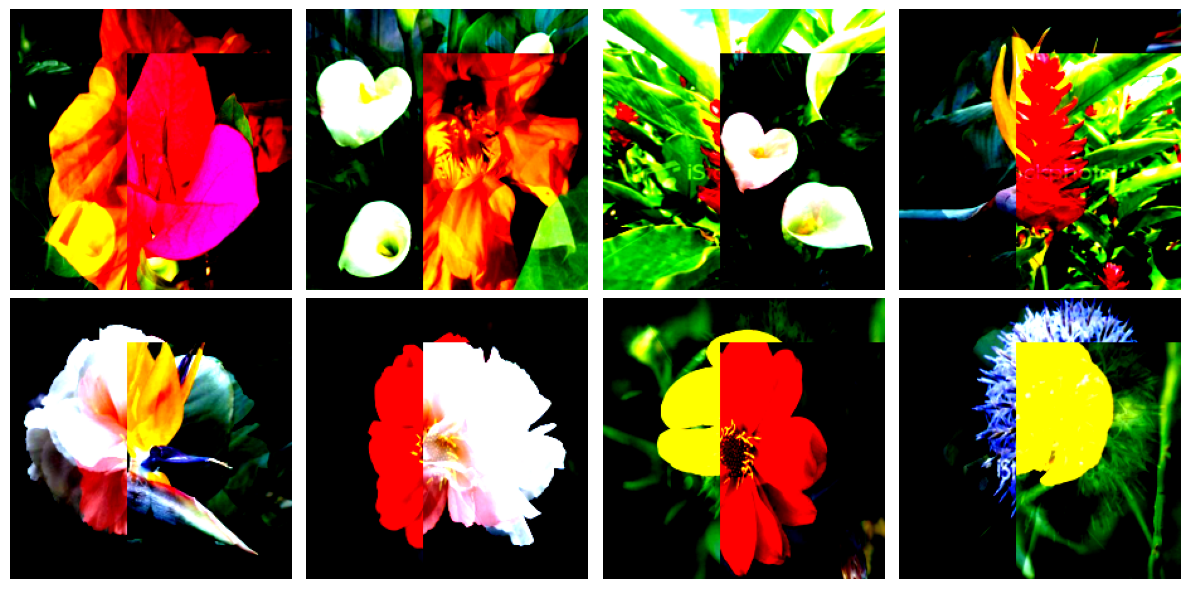

In [7]:
# Function to visualize the effect of MixUp on a batch of images
def visualize_mixup(images, labels, mixup_fn, num_images):

    mixed_images, labels = mixup_fn(images, labels)

    # Convert images from Tensor to NumPy for visualization
    def to_numpy(tensor):
        tensor = tensor.cpu().numpy().transpose(1, 2, 0) 
        tensor = np.clip(tensor, 0, 1) 
        return tensor

    plt.figure(figsize=(12, 6))
    
    for i in range(num_images):
        ax = plt.subplot(2, num_images//2, i + 1)
        mixed_img = to_numpy(mixed_images[i])
        ax.imshow(mixed_img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


images, labels = next(iter(train_loader))
images, labels = images.cuda(), labels.cuda()


# Visualize MixUp images
visualize_mixup(images, labels, mixup, num_images=8)

In [8]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES, bias=True)

if torch.cuda.is_available():
    model = model.cuda()

c:\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
class EarlyStopper:
    def __init__(self, patience=7, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = float('inf')
        self.verbose = verbose

    def early_stop(self, val_loss, model):
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
            torch.save(model.state_dict(), 'model.pth')
        else:
            self.counter += 1
           
        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")
            return True
        return False

In [10]:
# Optimizer and loss function and scheduler
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.3)


In [11]:
earlystopper = EarlyStopper()

In [12]:
accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, average='micro').to(device)

In [13]:
# Training function
def train_model(model, train_loader, train_val_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100):
    train_losses_history = []
    val_losses_history = []
    train_accuracies_history = []
    val_accuracies_history = []
    for epoch in range(num_epochs):

        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Evaluate the model on the training data but without mixup or cutmix
        model.eval() 
        correct = 0
        total = 0
        running_loss = 0
        with torch.no_grad():
            # Use train_val_loader for evaluating training accuracy
            for images, labels in train_val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()

                # Calculate accuracy on train_val_loader
                correct += accuracy(outputs, labels).item()
                total += 1

        # Calculate average training evaluation loss and accuracy
        average_train_val_loss = running_loss / total
        average_train_val_accuracy = correct / total
        
        train_losses_history.append(average_train_val_loss)
        train_accuracies_history.append(average_train_val_accuracy)
        
       # Validation
        model.eval() 
        correct = 0
        total = 0
        running_loss = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, labels)
                running_loss += loss.item()
                total += 1
                correct += accuracy(outputs, labels).item()

                

        average_val_loss = running_loss / total
        average_val_accuracy = correct / total
        val_losses_history.append(average_val_loss)
        val_accuracies_history.append(average_val_accuracy)

        scheduler.step()
        
        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {average_train_val_loss:.4f}, Train Accuracy: {average_train_val_accuracy:.4f}, Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")
        if earlystopper.early_stop(average_val_loss, model):
            break 
    
    return train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history



In [14]:
train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model, train_loader, train_val_loader, val_loader, loss_fn, optimizer, earlystopper, num_epochs=100
)

Epoch [0/100], Train Loss: 2.3530, Train Accuracy: 0.4146, Validation Loss: 2.8881, Validation Accuracy: 0.3382
Epoch [1/100], Train Loss: 1.1854, Train Accuracy: 0.7069, Validation Loss: 1.9835, Validation Accuracy: 0.5061
Epoch [2/100], Train Loss: 0.8761, Train Accuracy: 0.8214, Validation Loss: 1.8791, Validation Accuracy: 0.5484
Epoch [3/100], Train Loss: 0.5598, Train Accuracy: 0.9145, Validation Loss: 1.6518, Validation Accuracy: 0.6073
Epoch [4/100], Train Loss: 0.5786, Train Accuracy: 0.8830, Validation Loss: 1.8460, Validation Accuracy: 0.5412
Epoch [5/100], Train Loss: 0.4262, Train Accuracy: 0.9099, Validation Loss: 1.7546, Validation Accuracy: 0.5561
Epoch [6/100], Train Loss: 0.0687, Train Accuracy: 1.0000, Validation Loss: 1.0624, Validation Accuracy: 0.7626
Epoch [7/100], Train Loss: 0.0949, Train Accuracy: 1.0000, Validation Loss: 1.2026, Validation Accuracy: 0.7765
Epoch [8/100], Train Loss: 0.0423, Train Accuracy: 1.0000, Validation Loss: 0.9931, Validation Accuracy:

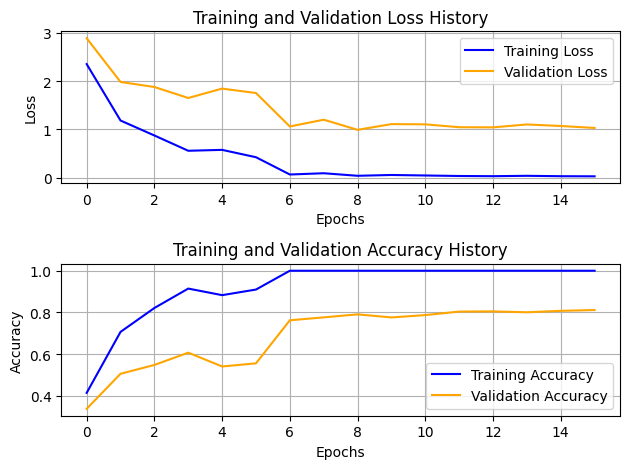

In [18]:
def plot_loss_and_accuracy(train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(train_losses_history, label='Training Loss', color='blue')
    ax1.plot(val_losses_history, label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(train_accuracies_history, label='Training Accuracy', color='blue')
    ax2.plot(val_accuracies_history, label='Validation Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout() 
    plt.show()

    
plot_loss_and_accuracy(train_losses, train_accuracies, val_losses, val_accuracies)

In [16]:
m = models.resnet18(pretrained=False)  # Set pretrained=True if needed
m.fc = torch.nn.Linear(m.fc.in_features, 102)
m.load_state_dict(torch.load('model.pth'))
m.eval()
if torch.cuda.is_available():
    m = m.to('cuda')
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            # Move data to GPU if available
            if torch.cuda.is_available():
                images, labels = images.to('cuda'), labels.to('cuda')
                
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            
            total += labels.size(0)  # Increment total count
            correct += (predicted == labels).sum().item()  # Increment correct predictions
    
    accuracy = correct / total  # Calculate accuracy
    return accuracy

# Call the evaluation function
accuracy = evaluate_model(m, test_loader)


c:\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Wt200\AppData\Local\Temp\ipykernel_54296\550693298.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe

In [17]:
accuracy

0.7684176288827451